## This is the original script and used for reference so pls do not mess with it. Create another file and copy to it, if you'd like!

# 1. Imports and Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic Model
mp_drawing = mp.solutions.drawing_utils # Drawing Utilities

In [3]:
def mediapipe_detection(image, model):
     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion from BGR -> RGB
     image.flags.writeable = False                  # Image is no longer writable
     results = model.process(image)                 # Make Prediction
     image.flags.writeable = True                   # Image is now writable
     image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color conversion from RGB -> BGR
     return image, results

In [4]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                          ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [79]:
cap = cv2.VideoCapture(0)
count = 0
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
     start = time.time()
     
     while cap.isOpened():
          
          if count < 30:
               
               # Read Feed
               ret, frame = cap.read()
               
               # Made detections
               # image, results = mediapipe_detection(frame, holistic)
               # print(results)
               
               # Draw landmarks
               # draw_styled_landmarks(image, results)
               # draw_styled_landmarks(frame, results)
               
               # Show to screen
               cv2.imshow('OpenCV Feed', frame)
               
               # Breaking gracefully
               if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
               count += 1
          else:
               end = time.time()
               print("Time Spent: "  + str(end - start))
               count = 0
               start = time.time()

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


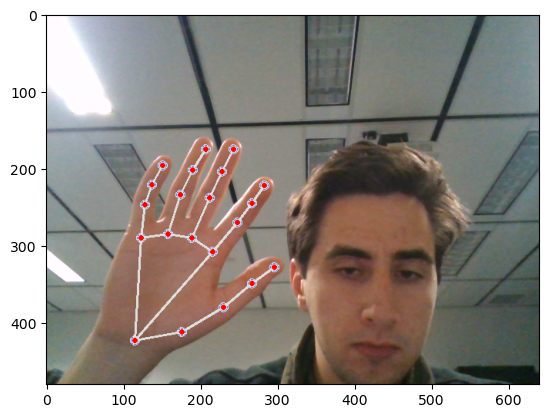

In [23]:
# draw_landmarks(frame, results)
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [7]:
# Stores all the keypoint values in an array
# Error checking if the hand isn't there, it'll insert a zero array
def extract_keypoints(results):
     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
     return np.concatenate([lh, rh])

# 4. Setup Folders for Collection

In [36]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('New_Data')

# Actions that we try to detect
actions = np.array(['a', 'b', 'c'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 20

In [37]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training & Testing

In [10]:
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
     
     # Loop through actions
     for action in actions:
          
          # Loop through sequences (videos)
          for sequence in range(no_sequences):
               
               # Loop through video length (sequence length)
               for frame_num in range(sequence_length):

                    # Read Feed
                    ret, frame = cap.read()
                    
                    # Made detections
                    image, results = mediapipe_detection(frame, holistic)
                     
                    # Draw landmarks
                    draw_styled_landmarks(frame, results)
                    
                    # NEW Apply wait logic
                    if frame_num == 0: 
                         cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                         cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                         # Show to screen
                         cv2.imshow('OpenCV Feed', image)
                         cv2.waitKey(1000)
                    else: 
                         cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                         # Show to screen
                         cv2.imshow('OpenCV Feed', image)
                    
                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                
                    # Show to screen
                    cv2.imshow('OpenCV Feed', frame)
                    
                    # Breaking gracefully
                    if cv2.waitKey(5) & 0xFF == ord('q'):
                         break

cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Lables and Features

In [19]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [38]:
label_map = {label:num for num, label in enumerate(actions)}

In [41]:
sequences, labels = [], []
# Loop through actions
for action in actions:
     # Go through each number number in actions
     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
         
          window = []
          # Grab all 30 frames and append them to window
          for frame_num in range(sequence_length):
               res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
               window.append(res)
          
          sequences.append(window)
          labels.append(label_map[action])
          
# Example: for hello, thank you, and i love you
     # You should have 90x30x1662
          # 30 for each one making 90
          # Each of the 90 have 30 np arrays
          # Each np array has 126 values

In [42]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [43]:
X.shape

(90, 20, 126)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# 7. Build and Train LSTM Neural Network

In [50]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from tensorflow import keras

In [46]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [47]:
model = Sequential()

In [48]:
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# To use LSTM in sequence, you need to set return_sequences to True. If the following is not LSTM, return False

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [32]:
# model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 5s 85ms/step - loss: 1.0862 - categorical_accuracy: 0.5059
Epoch 2/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.9900 - categorical_accuracy: 0.6824
Epoch 3/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.7742 - categorical_accuracy: 0.7059
Epoch 4/2000
3/3 [==============================] - 0s 96ms/step - loss: 3.0214 - categorical_accuracy: 0.6353
Epoch 5/2000
3/3 [==============================] - 0s 81ms/step - loss: 0.5974 - categorical_accuracy: 0.6824
Epoch 6/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.5860 - categorical_accuracy: 0.6353
Epoch 7/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.5610 - categorical_accuracy: 0.6588
Epoch 8/2000
3/3 [==============================] - 0s 119ms/step - loss: 0.5313 - categorical_accuracy: 0.6235
Epoch 9/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.4967 - categorical_accuracy: 0.6941

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 203,459
Trainable params: 203,459
Non-tr

In [ ]:
# How to run TensorBoard
# Using the command line
     # Navigate to the Logs/train folder
     # Run the following command:
          # tensorboard --logdir=.

In [51]:
model = keras.models.load_model(os.path.join('new_model.h5'))

# 8. Make Predictions

In [60]:
res = model.predict(X_test)

3/3 [==============================] - 0s 20ms/step


In [26]:
actions[np.argmax(res[4])]

'hello'

In [72]:
actions[np.argmax(y_test[4])]

'iloveyou'

# 9. Save Weights

In [58]:
# model.save('action.h5')

In [ ]:
# del model

In [31]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [54]:
yhat = model.predict(X_train)

3/3 [==============================] - 1s 13ms/step


In [55]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [82]:
multilabel_confusion_matrix(ytrue, yhat)
# Top Row:    TP | FP
# Bottom Row: FN | TN
# You want numbers in the top left and bottom right

array([[[56,  0],
        [ 0, 29]],

       [[56,  0],
        [ 0, 29]],

       [[58,  0],
        [ 0, 27]]], dtype=int64)

In [56]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [57]:
from scipy import stats

In [63]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [65]:
# 1. New detection variables
sequence = [] # Stores 30 frames and once we do, pass it to the prediction algorithm
sentence = [] # Concatenates our predictions
predictions = []
threshold = 0.5 # Confidence Metric... needs to be this confident to consider it a letter

cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
     while cap.isOpened():

          # Read feed
          ret, frame = cap.read()

          # Make detections
          image, results = mediapipe_detection(frame, holistic)
          print(results)
          
          # Draw landmarks
          draw_styled_landmarks(image, results)
          
          # 2. Prediction logic
          keypoints = extract_keypoints(results)
          sequence.append(keypoints)
          sequence = sequence[-20:]
          
          if len(sequence) == 20:
               res = model.predict(np.expand_dims(sequence, axis=0))[0] # Fixes the dimension from (30, 126) -> (1,30,126)
               print(actions[np.argmax(res)])
               predictions.append(np.argmax(res))
               
               
          #3. Viz logic
          # if np.unique(predictions[-10:])[0]==np.argmax(res):
               
          # Checking if out result is above the threshold
          if res[np.argmax(res)] > threshold: 
               
               if len(sentence) > 0:
                    # No repeat words in the sentence
                    if actions[np.argmax(res)] != sentence[-1]:
                         sentence.append(actions[np.argmax(res)])
               else: 
                    sentence.append(actions[np.argmax(res)])

          # Only keeping 5 values in a sentence. no need for this for the project
          if len(sentence) > 5: 
               sentence = sentence[-5:]

          # Viz probabilities
          image = prob_viz(res, actions, image, colors)
               
          cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
          cv2.putText(image, ' '.join(sentence), (3,30), 
                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
          
          # Show to screen
          cv2.imshow('OpenCV Feed', image)

          # Break gracefully
          if cv2.waitKey(10) & 0xFF == ord('q'):
               break
     
     cap.release()
     cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti